# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `dataproject.py` file includes a function which will be used multiple times in this notebook.

Imports and set magics:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2 
import numpy as np
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject

# import pydst
import pydst
dst = pydst.Dst(lang='en')

# 1. Read and clean data

## Employment data

**Read the education data** from dst and **clean it** :

In [2]:
educ_vars = dst.get_variables(table_id='HFUDD10')
educ_vars

#a. Download data
educ = dst.get_data(table_id = 'HFUDD10', variables={'Tid':['*'],'HERKOMST':['*'], 'HFUDD':['TOT','H20','H30', 'H40','H50','H60','H70'], 'KØN':['*']})

# b. drop columns
drop_these = ['BOPOMR','ALDER']
educ.drop(drop_these, axis=1, inplace=True)

# c. rename columns
educ.rename(columns = {'HERKOMST':'Ancestry', 'KØN':'Gender', 'TID':'Year', 'HFUDD':'HCEDUC', 'INDHOLD':'Units'}, inplace=True)

educ['HCEDUC']=educ.HCEDUC.astype(str).str[4:]

# d. Set index to year
educ.set_index('Year')
educ.head()

,Year,Ancestry,HCEDUC,Gender,Units
0,2006,Descendant,Upper secondary education,Women,2485
1,2006,Descendant,Upper secondary education,Men,2001
2,2006,Descendant,Upper secondary education,Total,4486
3,2006,Descendant,Vocational Education and Training (VET),Women,1938
4,2006,Descendant,Vocational Education and Training (VET),Men,1756


# Merge with population data set

## Clean the population data set

In [3]:
#Download population data from dst
pop = dst.get_data(table_id = 'FOLK1C', variables={'Tid':['*'], 'HERKOMST':['*'], 'KØN':['*']})

#Drop columns
drop_these = drop_these = ['OMRÅDE','ALDER', 'IELAND']
pop.drop(drop_these, axis=1, inplace=True)

#Rename columns
pop.rename(columns = {'HERKOMST':'Ancestry', 'KØN':'Gender', 'TID':'Year','INDHOLD':'Pop'}, inplace=True)

for val in ['Q2','Q3','Q4']: 
    I = pop.Year.str.contains(val)
    pop.drop(pop[I].index, inplace=True)

pop.Year.astype(str)
pop['Year']= pop.Year.astype(str).str[:4]

## Merge the datasets

In [4]:
#Merge population data with education data (merge pop with educ)
pop.Year = pop.Year.astype(int)
merged = pd.merge(educ, pop, how='inner',on=['Year','Ancestry','Gender'])
merged.head(10)

,Year,Ancestry,HCEDUC,Gender,Units,Pop
0,2008,Descendant,Upper secondary education,Women,3159,58393
1,2008,Descendant,Vocational Education and Training (VET),Women,2273,58393
2,2008,Descendant,Short cycle higher education,Women,395,58393
3,2008,Descendant,Vocational bachelors educations,Women,1048,58393
4,2008,Descendant,Bachelors programmes,Women,397,58393
5,2008,Descendant,Masters programmes,Women,610,58393
6,2008,Descendant,l,Women,19010,58393
7,2008,Descendant,Upper secondary education,Men,2454,60904
8,2008,Descendant,Vocational Education and Training (VET),Men,2070,60904
9,2008,Descendant,Short cycle higher education,Men,437,60904


## Calculate shares

In [5]:
#Make a new column with number of people with education as a share of number of people in poplation 
merged['Share'] = merged['Units']/merged['Pop'] * 100
merged.head(10)

,Year,Ancestry,HCEDUC,Gender,Units,Pop,Share
0,2008,Descendant,Upper secondary education,Women,3159,58393,5.409895
1,2008,Descendant,Vocational Education and Training (VET),Women,2273,58393,3.892590
2,2008,Descendant,Short cycle higher education,Women,395,58393,0.676451
3,2008,Descendant,Vocational bachelors educations,Women,1048,58393,1.794736
4,2008,Descendant,Bachelors programmes,Women,397,58393,0.679876
5,2008,Descendant,Masters programmes,Women,610,58393,1.044646
6,2008,Descendant,l,Women,19010,58393,32.555272
7,2008,Descendant,Upper secondary education,Men,2454,60904,4.029292
8,2008,Descendant,Vocational Education and Training (VET),Men,2070,60904,3.398792
9,2008,Descendant,Short cycle higher education,Men,437,60904,0.717523


# Graphical analysis

## Education by ancestry over time

In [6]:
merged.set_index('Year')
merged1 = merged.copy()

for val in ['Men', 'Women']: 
    I = merged1.Gender.str.contains(val)
    merged1 = merged1.loc[I == False] # keep everything else

# a. split
merged_grouped = merged1.groupby(['Ancestry', 'HCEDUC'])
merged_grouped_first = merged_grouped.Share.first()
merged_grouped_first.name = 'first'

# b. apply
merged1.set_index(['Ancestry','HCEDUC','Year'],inplace=True)
merged1 = merged1.join(merged_grouped_first,how='left',on=['Ancestry','HCEDUC'])
merged1.reset_index(inplace=True)

# c. combine
merged1['indexed'] = merged1['Share']/merged1['first']

# d. plot
def plot_index(dataframe, Educations):
    dataframe_indexed = dataframe.set_index(['Year'])
    I = dataframe_indexed.HCEDUC == Educations
    dataframe_indexed[I].groupby(['Ancestry'])['indexed'].plot(legend=True);
    
def plot_index_i(dataframe):
    widgets.interact(plot_index, dataframe = widgets.fixed(dataframe), 
    Educations=widgets.Dropdown(decription='Education', options=dataframe.HCEDUC.unique())
); 
    
#plot_index_i(educ1)
plot_index_i(merged1)

interactive(children=(Dropdown(description='Educations', options=('Upper secondary education', 'Vocational Edu…

In [7]:
## Education share by gender

In [8]:
#Only select the number of people with completed master programmes
for val in ['Masters programmes']: 
    I = merged.HCEDUC.str.contains(val)
    merged = merged.loc[I == True] # keep everything else
merged.head()

,Year,Ancestry,HCEDUC,Gender,Units,Pop,Share
5,2008,Descendant,Masters programmes,Women,610,58393,1.044646
12,2008,Descendant,Masters programmes,Men,701,60904,1.150992
19,2008,Descendant,Masters programmes,Total,1311,119297,1.098938
26,2008,Immigrants,Masters programmes,Women,10899,192713,5.655560
33,2008,Immigrants,Masters programmes,Men,12721,185952,6.841013


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


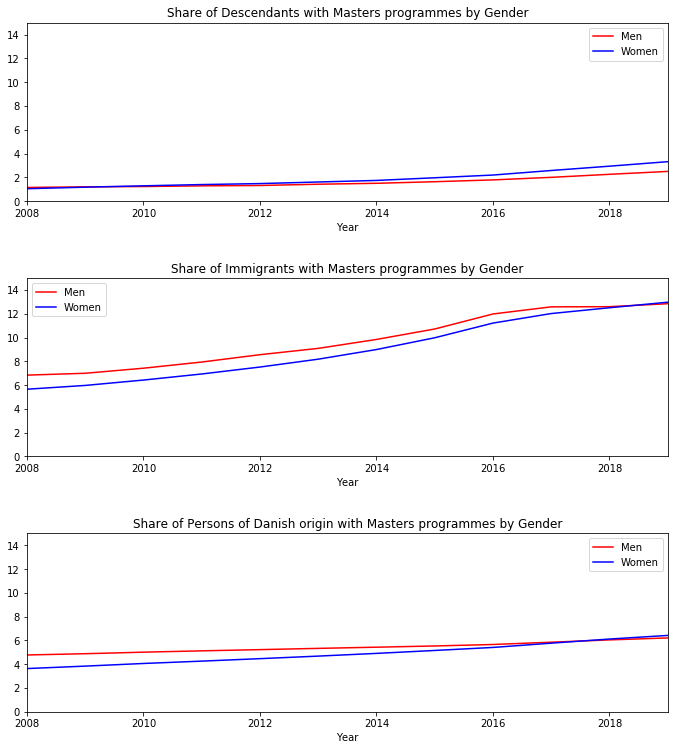

In [9]:
# Make a figure with 3 subplots showing the share of people with master programmes by ancestry and gender
plt.figure(figsize=(12,13))

#Figure 1: Plot with share of descendants with master programmes by gender
merged1 = merged.copy()
I = merged1.Ancestry == 'Descendant'
x = merged[I]

ax = plt.subplot(311)

J = x.Gender == 'Men'
y1 = x[J]
y1.rename(columns = {'Share':'Men'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Men', ylim=(0,15), color='red', ax=ax)

K = x.Gender == 'Women'
y2 = x[K]
y2.rename(columns = {'Share':'Women'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Women', ylim=(0,15), color='blue', ax=ax)
ax.set_title('Share of Descendants with Masters programmes by Gender')

#Figure 2: Plot with share of immigrants with master programmes by gender
merged2 = merged.copy()
I = merged2.Ancestry == 'Immigrants'
x = merged2[I]

ax1 = plt.subplot(312)

J = x.Gender == 'Men'
y1 = x[J]
y1.rename(columns = {'Share':'Men'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Men', ylim=(0,15), color='red', label='Men', ax=ax1)

K = x.Gender == 'Women'
y2 = x[K]
y2.rename(columns = {'Share':'Women'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Women', ylim=(0,15), color='blue', ax=ax1, label='Women')
ax1.set_title('Share of Immigrants with Masters programmes by Gender')

#Figure 3: Plot with share of persons of danish origin with master programmes by gender
merged3 = merged.copy()
I = merged3.Ancestry == 'Persons of Danish origin'
x = merged3[I]

ax2 = plt.subplot(313)

J = x.Gender == 'Men'
y1 = x[J]
y1.rename(columns = {'Share':'Men'}, inplace=True)
y1.plot(kind='line', x = 'Year', y='Men', ylim=(0,15), color='red', ax=ax2)

K = x.Gender == 'Women'
y2 = x[K]
y2.rename(columns = {'Share':'Women'}, inplace=True)
y2.plot(kind='line', x = 'Year', y='Women', ylim=(0,15), color='blue', ax=ax2)
ax2.set_title('Share of Persons of Danish origin with Masters programmes by Gender')

plt.tight_layout(pad=10,h_pad=3,w_pad=20)

widgets.interact(interactive_figure,
    alphas=widgets.fixed(alphas),
    =widgets.Dropdown(description="$p_1$", options=[0.5,1,1.5,2.0,2.5,3], value=2),
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)


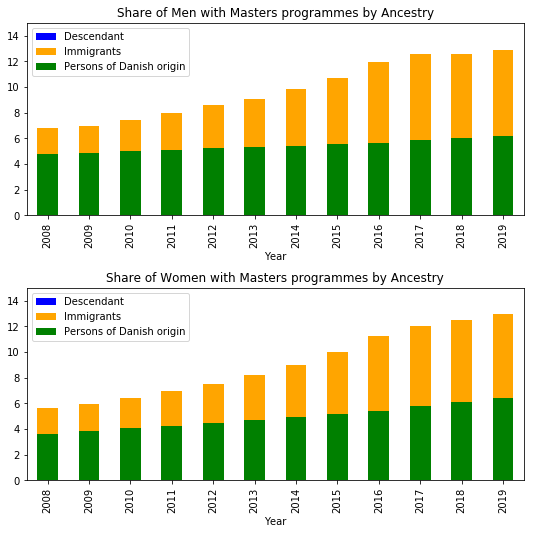

In [39]:
# Make a figure with 3 subplots showing the share of people with master programmes by ancestry and gender
plt.figure(figsize=(10,10))

#Figure 1: Plot with share of men with master programmes by ancestry
merged4 = merged.copy()
I = merged4.Gender == 'Men'
x = merged[I]

ax = plt.subplot(211)

J = x.Ancestry == 'Descendant'
y1 = x[J]
y1.rename(columns = {'Share':'Descendant'}, inplace=True)
y1.plot(kind='bar',stacked=True, x = 'Year', y='Descendant', ylim=(0,15), color='blue', ax=ax)

K = x.Ancestry == 'Immigrants'
y2 = x[K]
y2.rename(columns = {'Share':'Immigrants'}, inplace=True)
y2.plot(kind='bar',stacked=True, x = 'Year', y='Immigrants', ylim=(0,15), color='orange', ax=ax)

K = x.Ancestry == 'Persons of Danish origin'
y2 = x[K]
y2.rename(columns = {'Share':'Persons of Danish origin'}, inplace=True)
y2.plot(kind='bar',stacked=True, x = 'Year', y='Persons of Danish origin', ylim=(0,15), color='green', ax=ax)
ax.set_title('Share of Men with Masters programmes by Ancestry')

#Figure 2: Plot with share of women with master programmes by ancestry
merged5 = merged.copy()
I = merged5.Gender == 'Women'
x = merged[I]

ax1 = plt.subplot(212)

J = x.Ancestry == 'Descendant'
y1 = x[J]
y1.rename(columns = {'Share':'Descendant'}, inplace=True)
y1.plot.bar(stacked=True, x = 'Year', y='Descendant', ylim=(0,15), color='blue', ax=ax1)

K = x.Ancestry == 'Immigrants'
y2 = x[K]
y2.rename(columns = {'Share':'Immigrants'}, inplace=True)
y2.plot.bar(stacked=True, x = 'Year', y='Immigrants', ylim=(0,15), color='orange', ax=ax1)

L = x.Ancestry == 'Persons of Danish origin'
y3 = x[L]
y3.rename(columns = {'Share':'Persons of Danish origin'}, inplace=True)
y3.plot.bar(stacked=True, x = 'Year', y='Persons of Danish origin', ylim=(0,15), color='green', ax=ax1)
ax1.set_title('Share of Women with Masters programmes by Ancestry')


plt.tight_layout(pad=10,h_pad=1,w_pad=10)

## Income data

**Read the income data** in ``INDKP101.xlsx`` and **clean it**:

In [32]:
# a. load
#inc = pd.read_excel('INDKP101.xlsx', skiprows=2)

# b. drop and rename columns
#inc.drop([f'Unnamed: {i}' for i in range(3)], axis=1, inplace=True)
#inc.rename(columns = {'Unnamed: 3':'municipality'}, inplace=True)

# c. drop rows with missing
#inc.dropna(inplace=True)

# d. remove non-municipalities
#inc = dataproject.only_keep_municipalities(inc)

# e. convert to long
#inc.rename(columns = {str(i):f'income{i}' for i in range(1986,2018)}, inplace=True)
#inc_long = pd.wide_to_long(inc, stubnames='income', i='municipality', j='year').reset_index()

# f. show
#inc_long.head(5)

> **Note:** The function ``dataproject.only_keep_municipalities()`` is used on both the employment and the income datasets.

## Explore data set

In order to be able to **explore the raw data**, we here provide an **interactive plot** to show, respectively, the employment and income level in each municipality

The **static plot** is:

In [ ]:
def plot_empl_inc(empl,inc,dataset,municipality): 
    
    if dataset == 'Employment':
        df = empl
        y = 'employment'
    else:
        df = inc
        y = 'income'
    
    I = df['municipality'] == municipality
    ax = df.loc[I,:].plot(x='year', y=y, style='-o')

The **interactive plot** is:

In [ ]:
widgets.interact(plot_empl_inc, 
    
    empl = widgets.fixed(empl_long),
    inc = widgets.fixed(inc_long),
    dataset = widgets.Dropdown(description='Dataset', 
                               options=['Employment','Income']),
    municipality = widgets.Dropdown(description='Municipality', 
                                    options=empl_long.municipality.unique())
                 
); 

ADD SOMETHING HERE IF THE READER SHOULD KNOW THAT E.G. SOME MUNICIPALITY IS SPECIAL.

# Merge data sets

We now create a data set with **municpalities which are in both of our data sets**. We can illustrate this **merge** as:

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('inc', 'empl'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

In [ ]:
merged = pd.merge(empl_long, inc_long, how='inner',on=['municipality','year'])

print(f'Number of municipalities = {len(merged.municipality.unique())}')
print(f'Number of years          = {len(merged.year.unique())}')

# Analysis

To get a quick overview of the data, we show some **summary statistics by year**:

In [ ]:
merged.groupby('year').agg(['mean','std']).round(2)

ADD FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.